In [1]:
using Flux

Wczytanie oraz przygotowanie danych

In [2]:
using Flux.Data.MNIST
using Images


images = MNIST.images();
labels = MNIST.labels();

In [3]:
preprocess(img) = vec(Float64.(img))#zmieniamy na float i na vektor bo tak będziemy pracować z siecia neuronową


xs = preprocess.(images[1:4000])# używamy tej funkci 5 tys razy aby stworzyc set uczacy
testowy_x = preprocess.(images[10001:12000])# set testowy

ys = [Flux.onehot(labels, 0:9) for labels in labels[1:4000]] # zmieniamy 5 na wertor [ 0 0 0 0 0 1 0 0 0 0 ]
testowy_y = [Flux.onehot(labels, 0:9) for labels in labels[10001:12000]]

2000-element Vector{Flux.OneHotVector}:
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 ⋮
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

Wczytujemy baze danych MNIST z zdjeciami liczb 
Mamy 60 tys zdjec (imagies) i podpisów do nich(labels)
images to jedno wymiarowa tablica dwuwyiarowych macierzy 28x28
images[1] = to jedno zdjecie

Tworzenie grafu

In [4]:
#bebechy
abstract type GraphNode end
abstract type Operator <: GraphNode end

struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        reset!(node)
    end
    return last(order).output
end

update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed=1.0)
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end


import Base: ^
^(x::GraphNode, n::GraphNode) = ScalarOperator(^, x, n)
forward(::ScalarOperator{typeof(^)}, x, n) = return x^n
backward(::ScalarOperator{typeof(^)}, x, n, g) = tuple(g * n * x ^ (n-1), g * log(abs(x)) * x ^ n)

import Base: sin
sin(x::GraphNode) = ScalarOperator(sin, x)
forward(::ScalarOperator{typeof(sin)}, x) = return sin(x)
backward(::ScalarOperator{typeof(sin)}, x, g) = tuple(g * cos(x))

import Base: *
import LinearAlgebra: mul!
# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A, x) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A, x, g) = let
    #print("mul ")
    #print(g)
    tuple(g * x', A' * g)
end

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x, y) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x, y, g) = let  #w*x
    #print("* ")
    𝟏 = ones(length(node.output))
    Jx = diagm(y .* 𝟏)# to zostaje tylko y wiec to dajesz
    Jy = diagm(x .* 𝟏)
    
    tuple(Jx' * g, Jy' * g)
end

Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x, y) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x, y, g) = tuple(g,-g)

Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x, y) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x, y, g) = tuple(g, g)

import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x, g) = let
    #print("sum ")
    #print(g)
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x, y) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x, y::Real, g) = let
    𝟏 = ones(length(node.output))#robisz jedynki 
    Jx = diagm(𝟏 ./ y)
    Jy = (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end


import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x, y) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x, y, g) = let
    Jx = diagm(isless.(y, x))
    #print("max ")
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

import Base: ^
Base.Broadcast.broadcasted(^, x::GraphNode, y::GraphNode) = BroadcastedOperator(^, x, y)
forward(::BroadcastedOperator{typeof(^)}, x, y) = return x.^y
backward(node::BroadcastedOperator{typeof(^)}, x, y::Real, g) = let
    #print("^ ")
    #print(g)
    𝟏 = ones(length(node.output))#robisz jedynki 
    Jx = diagm(y .* x .^ (y.-1))
    Jy = diagm(x .^ y .* log.(broadcast(abs, x)))
    tuple(Jx' * g, Jy' * g)
end

σ(x::GraphNode) = BroadcastedOperator(σ, x)
forward(::BroadcastedOperator{typeof(σ)}, x) = return @. one(x) / (one(x) + exp(-x))
backward(::BroadcastedOperator{typeof(σ)}, x, g) = let
    a=exp.(-x)
    Jx=diagm(@.a/(one(x)+a)^2)
    tuple(Jx' * g)
end

mean_squared_loss_in_graf(x::GraphNode, y::GraphNode) = BroadcastedOperator(mean_squared_loss_in_graf, x, y)
Base.Broadcast.broadcasted(mean_squared_loss_in_graf, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(mean_squared_loss_in_graf)}, x, y) = return (1/length(x)) .* sum((x .- y) .^ 2.0)
backward(::BroadcastedOperator{typeof(mean_squared_loss_in_graf)}, x, y, g) = let
    𝟏 = ones(length(y))#sum
    Jy = ((1/length(y)).*𝟏')'#sum*0.1
    #print(Jy)
    Jy=diagm(2 .* (x .- y))*Jy#^2
    #print(Jy)
    Jy=-Jy#x-y
    #print(Jy)
    Jx=Jy#test
    tuple(Jx * g, Jy * g)
end

backward (generic function with 12 methods)

In [5]:
# siec neuronowa
using LinearAlgebra
Wh  = Variable(randn(20,784), name="wh")#tworzymy losowe wagi 
Wo  = Variable(randn(10,20), name="wo")
x = Variable(xs[1], name="x")#wczytujemy pierwsze dane
y = Variable(Vector{Float64}(ys[1]), name="y")

#rózne funkcje aktywacji
#σ(x) = one(x) / (one(x) + exp(-x))#aktualnie używana ale zamieniona na czesc grafu
linear(x)=x
ReLU(x)= max.(Constant(0.0),x) 

epos=100

#różne funkcje strat
# function mean_squared_loss(y, ŷ)#aktualnie używana ale zamieniona na czesc grafu
#     return Constant(0.1) .* sum((y .- ŷ) .^ Constant(2.0))
# end   a *sum(b-x)^2

function cross_entropy(y, ŷ)
    return sum(Constant(-1.0).*y.*log.(ŷ))
end

#definicja grafu
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(wo, x̂)
    ŷ.name = "ŷ"
    E = mean_squared_loss_in_graf(y, ŷ)
    E.name = "loss"
    return topological_sort(E)
end

graph = net(x, Wh, Wo, y)

for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. var y
 ┣━ ^ 10-element Vector{Float64}
 ┗━ ∇ Nothing
2. var wo
 ┣━ ^ 10×20 Matrix{Float64}
 ┗━ ∇ Nothing
3. var wh
 ┣━ ^ 20×784 Matrix{Float64}
 ┗━ ∇ Nothing
4. var x
 ┣━ ^ 784-element Vector{Float64}
 ┗━ ∇ Nothing
5. op.?(typeof(mul!))
6. op.x̂(typeof(σ))
7. op.ŷ(typeof(mul!))
8. op.loss(typeof(mean_squared_loss_in_graf))


In [6]:
forward!(graph)


9.425960847462731

In [7]:
backward!(graph)

In [8]:
# for (i,n) in enumerate(graph)
#     try
#         print(i, ". "); println(n.gradient)
#     catch
#         println("Constans")
#     end

# end

In [9]:
import ProgressMeter: @showprogress
using Flux: onecold
#funcje gradientowe
function steepest_descent(step)
    Wh.output -= step*Wh.gradient
    Wo.output -= step*Wo.gradient
end


function steepest_descent_momentum(step,changeWo,changeWh,momentum = 0.6)
    new_changeWh = step * Wh.gradient + momentum * changeWh
    new_changeWo = step * Wo.gradient + momentum * changeWo
    
    Wh.output -= new_changeWh
    Wo.output -= new_changeWo
    
    changeWh=new_changeWh
    changeWo=new_changeWo
    return changeWh,changeWo
end

#funkcja zmieniajaca kolejnosc setów
using Random
    function double_shuffle(set1,set2)
    @assert length(set1) == length(set2) "wielkości zbiorów do tasowania muszą być równę"
    temp_set1=copy(set1)
    temp_set2=copy(set2)
    new_order=shuffle(1:length(set1))
    i=0
    for order in new_order
        i+=1
        temp_set1[i]=set1[order]
        temp_set2[i]=set2[order]
    end
    return temp_set1,temp_set2
end


#funcje pokazujące postęp
function test(set_x,set_y)
    good_maches=0
        for i=1:length(set_x)
            x.output=set_x[i]
            forward!(graph)
            if onecold(Vector{Float64}(set_y[i])) == onecold(graph[7].output)
                good_maches+=1
            end
        end
    return 100.0*good_maches/float(length(set_y))
end

function loss_test(set_x,set_y)
    loss=0.0
        for i=1:length(set_x)
            x.output=set_x[i]
            y.output=Vector{Float64}(set_y[i])
            loss+=forward!(graph)
        end
    return loss/float(length(set_y))
end



loss_test (generic function with 1 method)

In [10]:
println("Acc zbioru uczącego:",test(xs,ys))
println("Acc zbuoru testowo:",test(testowy_x,testowy_y))
println("Straty zbioru uczącego:",loss_test(xs,ys))
println("Straty zbioru uczącego:",loss_test(testowy_x,testowy_y))

Acc zbioru uczącego:6.325
Acc zbuoru testowo:5.95
Straty zbioru uczącego:10.620312566256558
Straty zbioru uczącego:10.393272578227077


┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1423
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


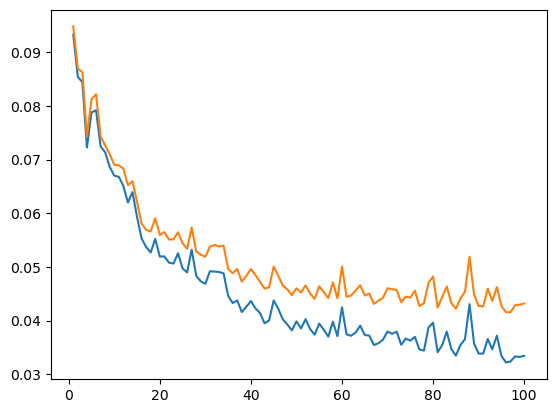

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001E86190>
 PyObject <matplotlib.lines.Line2D object at 0x0000000001E86130>

In [11]:
#mini batch
changeWh = zero(randn(20,784))
changeWo = zero(randn(10,20))
using PyPlot

j=0
batch_size=5
grad_wo=zeros(10,20)
grad_wh=zeros(20,784)

yyy = zeros(epos, 2)
@showprogress for i=1:epos
xs,ys=double_shuffle(xs,ys)
    for i=1:length(xs)
        x.output=xs[i]
        y.output=Vector{Float64}(ys[i])
        forward!(graph)
        backward!(graph)
        
        grad_wo+=Wo.gradient
        grad_wh+=Wh.gradient
        j+=1
        if j ==batch_size
            Wo.gradient = grad_wo/batch_size
            Wh.gradient = grad_wh/batch_size
            changeWh,changeWo = steepest_descent_momentum(0.2,changeWo,changeWh)
            j=0
            grad_wo=zeros(10,20)
            grad_wh=zeros(20,784)
        end
    end
yyy[i,1]=loss_test(xs,ys)
yyy[i,2]=loss_test(testowy_x,testowy_y)
end
xxx = 1:epos
plot(xxx, yyy)


In [12]:
println("Acc zbioru uczącego:",test(xs,ys))
println("Acc zbuoru testowo:",test(testowy_x,testowy_y))
println("Straty zbioru uczącego:",loss_test(xs,ys))
println("Straty zbioru uczącego:",loss_test(testowy_x,testowy_y))

Acc zbioru uczącego:76.15
Acc zbuoru testowo:70.05
Straty zbioru uczącego:0.03343774871164767
Straty zbioru uczącego:0.04319318845783661


In [13]:

epos=10

10

In [14]:
for i=1:50
        x.output=xs[i]
        y.output=Vector{Float64}(ys[i])
        forward!(graph)
        backward!(graph)
        print(onecold(Vector{Float64}(ys[i]))) 
        print(onecold(graph[7].output))
        println()
end

99
39
1010
22
88
11
77
64
99
1010
55
55
1010
22
77
44
64
88
1010
99
88
55
55
22
64
88
11
44
55
77
39
77
64
34
88
55
39
55
44
22
49
39
55
88
99
35
11
39
44
44


In [15]:
using BenchmarkTools

In [16]:
@btime forward!(graph)


  37.400 μs (25 allocations: 1.45 KiB)


0.03916662766336254

In [17]:
@btime  backward!(graph)

  50.800 μs (118 allocations: 140.22 KiB)


In [19]:
    tmp_res = Vector{BenchmarkTools.Trial}()
    tmp_res = @benchmark backward!(graph)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  51.000 μs …   7.047 ms  ┊ GC (min … max): 0.00% … 98.10%
 Time  (median):     55.300 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.570 μs ± 116.655 μs  ┊ GC (mean ± σ):  6.58% ±  3.80%

   ▄▆▇█▇▅▅▄▃▃▃▂▂▁▁▁▁  ▁        ▁▂▂▃▂▁                          ▂
  ▇██████████████████████▇█▆█▇▇████████▇█▇▇▆▇▇▆▅▆▆▆▆▆▅▄▆▄▅▄▄▄▅ █
  51 μs         Histogram: log(frequency) by time       103 μs <

 Memory estimate: 140.22 KiB, allocs estimate: 118.

In [20]:
using ForwardDiff

In [24]:
σ(x::Vector{Float64})=return @. one(x) / (one(x) + exp(-x))

σ (generic function with 2 methods)

In [44]:
function siec(Wh::Matrix,Wo::Matrix,x::Vector,y::Vector)
    x̂ = dense(Wh, x, σ)
    ŷ = dense(Wo, x̂)
    return (1/length(y)) .* sum((y .- ŷ) .^2.0)
end

siec (generic function with 2 methods)

In [45]:
    Wh  = randn(20,784)
    Wo  = randn(10,20)
    x = xs[1]
    y = Vector{Float64}(ys[1])
siec(Wh,Wo,x,y)

11.700345831542265

In [46]:
ForwardDiff.gradient(siec, [Wh,Wo,x,y])

LoadError: MethodError: no method matching gradient(::typeof(siec), ::Matrix{Float64}, ::Matrix{Float64}, ::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  gradient(::Any, ::AbstractArray) at C:\Users\Barteu pieseł\.julia\packages\ForwardDiff\wAaVJ\src\gradient.jl:16
[0m  gradient(::Any, ::AbstractArray, [91m::ForwardDiff.GradientConfig{T}[39m) where T at C:\Users\Barteu pieseł\.julia\packages\ForwardDiff\wAaVJ\src\gradient.jl:16
[0m  gradient(::Any, ::AbstractArray, [91m::ForwardDiff.GradientConfig{T}[39m, [91m::Val{CHK}[39m) where {T, CHK} at C:\Users\Barteu pieseł\.julia\packages\ForwardDiff\wAaVJ\src\gradient.jl:16
[0m  ...

In [18]:
for (i,n) in enumerate(graph)
    try
        print(i, ". "); println(n.gradient)
    catch
        println("Constans")
    end

end

1. [-335.2467308035413; -206.38622736357718; 181.85666716692174; -8686.751341218853; -608.0824577444204; 6105.089822658039; 1215.0279061984006; 15.682718589728873; 906.1258959167495; 1417.366798673552;;]
2. [-1.4522720755060008e7 -1.6318888200554052e-6 -50.59894887699947 -6.082137894719247e-5 -4.274507046891802e-8 -1.452272075505998e7 -3.6297856450465136 -1.4291623863469134e-5 -7.396311945816371e-5 -0.0005041877841530239 -0.0002071325463665939 -1.4522720715805868e7 -0.0035201637793202895 -6.838614776893372e-5 -1.4522720755059827e7 -1.4522720755051153e7 -3.1280752652237976e-7 -1.4522720755060066e7 -1.4522720755059514e7 -1.4522720755057862e7; -8.940548176287284e6 -1.0046313538712448e-6 -31.149971670886263 -3.744315392390489e-5 -2.631492874315596e-8 -8.940548176287265e6 -2.2345863407052944 -8.798279180862401e-6 -4.55335363074998e-5 -0.000310390542525929 -0.00012751594834751342 -8.940548152121466e6 -0.0021671003931180758 -4.210021379814971e-5 -8.940548176287174e6 -8.94054817628183e6 -1.925

3. [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.035528756335002 -13.461873832354993 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -20.71057512669995 -24.95624302767335 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -26.405983286542412 -24.95624302767335 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.035528756335002 -2.588821890837494 -2.588821890837494 -0.20710575126699862 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -26.405983286542412 -24.95624302767335

 1.275059276987522e11 1.0482700775233424e11 5.039759988092994e10 5.039759988092994e10 1.1641845572494775e11 1.275059276987522e11 1.275059276987522e11 4.737374388807415e10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.039759988092999e8 4.8381695885692024e10 1.275059276987522e11 9.021170378686429e10 1.0583495974995245e10 0.0 0.0 0.0 0.0 2.4190847942846012e10 1.1490652772851878e11 1.275059276987522e11 1.275059276987522e11 1.275059276987522e11 1.275059276987522e11 1.275059276987522e11 2.3182895945227737e10 1.0079519976185998e9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.039759988092999e8 9.071567978567451e9 4.031807990474399e9 0.0 0.0 0.0 0.0 0.0 0.0 2.3686871944037075e10 8.769182379281853e10 1.275059276987522e11 1.275059276987522e11 7.912423181306009e10 1.6631207960706762e10 1.0079519976185998e9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0159039952371995e9 6.047711985711503e9 6.047711985711503e9 1.0079519976185998e9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

 -141.11901366579605 -87.01409538286153 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -141.67679632850508 -141.11901366579605 -61.91387556088244 0.0 -36.255873076192366 -131.6367083997153 -141.11901366579605 -141.11901366579605 -141.11901366579605 -117.69214183194735 -11.15565325421308 0.0 0.0 0.0 0.0 0.0 -47.969308993116016 -139.44566567766245 -141.11901366579605 -50.20043964395917 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -141.67679632850508 -141.11901366579605 -61.91387556088244 -35.698090413481836 -132.19449106242385 -141.11901366579605 -121.03883780821099 -23.984654496558008 -107.0942712404452 -141.11901366579605 -104.86314058960332 -10.597870591502328 0.0 0.0 0.0 -46.295961004984605 -127.73222976073906 -141.11901366579605 -86.45631272015089 -0.5577826627106537 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -82.55183408117702 -141.11901366579605 -129.9633604115814 -132.75227372513652 -141.11901366579605 -133.8678390505558 -40.16035171516676 0.0 -30.120263786375094 -127.73222976073906 -141.11901366579605 -56.33604893377

 0.0 1.2559095768191319e9 1.8280461618145264e10 9.210003563340351e9 0.0 0.0 0.0 0.0 0.0 0.0 2.0513189754712494e10 3.53050136594712e10 2.972319331805277e10 5.581820341418402e8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.5584104676541885e10 3.3630467557045795e10 0.0 0.0 0.0 0.0 0.0 6.9772754267730055e9 3.53050136594712e10 2.6653192130272728e10 0.0 0.0 0.0 0.0 0.0 0.0 4.744547290205631e9 3.3630467557045795e10 3.53050136594712e10 4.186365256063794e9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.5444559168006996e10 3.488637713386508e10 1.102409517430126e10 0.0 0.0 0.0 0.0 1.0884549665765747e10 3.53050136594712e10 2.6653192130272728e10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.2932740014368404e10 3.53050136594712e10 1.8001370601074192e10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.5444559168006996e10 3.4467740608258415e10 7.954093986521158e9 0.0 0.0 0.0 0.0 2.428091848516993e10 3.53050136594712e10 2.6653192130272728e10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.2932740014368404e10 3.53050136594712e10 1.8001370601074192e10 0.0 0.0 0.0 0.0 0.0 0.0 0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2133.191881921339 -27731.49446497721 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -42663.83763842623 -51409.92435430427 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -54396.392988993546 -51409.92435430427 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2133.191881921339 -5332.979704803279 -5332.979704803279 -426.638376384264 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -54396.392988993546 -51409.92435430427 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -14719.023985257218 -40743.96494469748 -539

 8.845026454270322e6 1.0376846678194171e6 0.0 0.0 0.0 0.0 2.371850669301554e6 1.1266290679182272e7 1.250162956944343e7 1.250162956944343e7 1.250162956944343e7 1.250162956944343e7 1.250162956944343e7 2.273023558080652e6 98827.1112208981 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 49413.55561044905 889444.0009880774 395308.4448835924 0.0 0.0 0.0 0.0 0.0 0.0 2.322437113691109e6 8.597958676218089e6 1.250162956944343e7 1.250162956944343e7 7.757928230840445e6 1.6306473351448162e6 98827.1112208981 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 197654.2224417962 592962.6673253885 592962.6673253885 98827.1112208981 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

 1.859289462397414e8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.027304637493251e8 3.01538611529837e8 1.3229559636289293e8 0.0 7.74703942665595e7 2.812771237985833e8 3.01538611529837e8 3.01538611529837e8 3.01538611529837e8 2.5148081831144828e8 2.3837044389710523e7 0.0 0.0 0.0 0.0 0.0 1.0249929087575454e8 2.9796305487138164e8 3.01538611529837e8 1.0726669975369728e8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.027304637493251e8 3.01538611529837e8 1.3229559636289293e8 7.6278542047074e7 2.824689760180721e8 3.01538611529837e8 2.5863193162835705e8 5.124964543787727e7 2.288356261412231e8 3.01538611529837e8 2.2406821726327938e8 2.264519217022521e7 0.0 0.0 0.0 9.89237342172984e7 2.7293415826218706e8 3.01538611529837e8 1.8473709402025783e8 1.1918522194855313e6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.7639412848385715e8 3.01538611529837e8 2.7770156714012814e8 2.836608282375569e8 3.01538611529837e8 2.860445326765267e8 8.581335980295774e7 0.0 6.436001985221834e7 2.7293415826218706e8 3.01538611529837e8 1.2037707416803876e8 0.0

 -1.4386168408361499e6 -517447.16409521183 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.444303073408608e6 -1.3703820499664457e6 0.0 0.0 0.0 0.0 0.0 -51176.09315227367 -744896.4669942056 -375291.34978334216 0.0 0.0 0.0 0.0 0.0 0.0 -835876.1881538068 -1.4386168408361499e6 -1.2111675379371517e6 -22744.93028989955 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.449989305981095e6 -1.3703820499664457e6 0.0 0.0 0.0 0.0 0.0 -284311.6286237422 -1.4386168408361499e6 -1.0860704213427005e6 0.0 0.0 0.0 0.0 0.0 0.0 -193331.90746414257 -1.3703820499664457e6 -1.4386168408361499e6 -170586.9771742455 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.444303073408608e6 -1.421558143118705e6 -449212.37322551635 0.0 0.0 0.0 0.0 -443526.14065303875 -1.4386168408361499e6 -1.0860704213427005e6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.3419508871040728e6 -1.4386168408361499e6 -733524.0018492586 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.444303073408608e6 -1.4044994454012853e6 -324115.256631066 0.0 0.0 0.0 0.0 -989404.4676106282 -1.4386168408361499e6 -1.08607042134

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3124.329240279689 40616.28012363637 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 62486.58480559397 75296.33469074078 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 79670.39562713225 75296.33469074078 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3124.329240279689 7810.823100699246 7810.823100699246 624.865848055939 0.0 0.0

 6.311031920239424 113.5985745643108 50.48825536191539 0.0 0.0 0.0 0.0 0.0 0.0 296.61850025125585 1098.1195541216646 1596.6910758205806 1596.6910758205806 990.8320114775973 208.26405336790063 12.622063840478848 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 25.244127680957696 75.73238304287268 75.73238304287268 12.622063840478848 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

 504.6289431997654 50.999733621252936 0.0 0.0 0.0 222.78831002968477 614.6809999614153 679.1017161145814 416.050458489164 2.684196506381718 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 397.26108294449716 679.1017161145814 625.4177859869448 638.8387685188536 679.1017161145814 644.2071615316135 193.26214845948422 0.0 144.9466113446126 614.6809999614153 679.1017161145814 271.10384714455427 0.0 0.0 217.41991701692015 582.4706418848335 679.1017161145814 569.0496593529272 67.10491265954336 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 220.1041135233024 679.1017161145814 679.1017161145814 679.1017161145814 646.8913580379966 190.57795195310237 0.0 0.0 0.0 499.26055018700436 679.1017161145814 558.3128733273999 268.41965063817344 268.41965063817344 620.0493929741782 679.1017161145814 679.1017161145814 252.3144715998827 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.684196506381718 257.6828646126467 679.1017161145814 480.4711746423285 56.368126634016214 0.0 0.0 0.0 0.0 128.84143230632336 611.9968034550332 679.1017161145814 

4. [-6.532863815005648e10; 2.7074850082167224e11; -6.944558916030504e10; -6.881178237869911e10; -1.0613653310264409e11; 5.052861912290615e10; 4.277547743300812e10; -5.7207756277026596e10; -1.1944405886804825e10; -8.650894196961314e10; -7.955682598490828e10; -5.733544846525831e10; 6.90052802234968e10; 2.823106995165286e11; -1.0352488382362343e11; 1.249845722314434e11; 1.8573168205708176e10; -7.760879796463034e10; -1.2152230930234793e11; 2.1305968835838425e11; 2.0306574501468777e11; -1.3354765119596756e10; 1.203423044287245e11; 1.8523666406229367e11; -2.0284333488385342e11; 2.87135435450322e10; -4.225856261062209e10; -2.1608131222422232e11; -2.5292340355406952e11; 6.053474128271525e10; 4.448199023226819e10; -1.289167212978377e10; -1.7121404845692737e11; 1.8641173419023257e11; -1.4072444656427386e11; -1.682389996611782e11; 1.4412029472990993e10; -4.398119598983462e10; 5.232582182926803e10; 5.630534791404422e10; 1.7357719236394615e10; 1.515692067753355e11; 7.222944260783932e10; 1.841094869

; 4.310188204805086e10; -1.8325251924253838e10; -1.418389837613255e11; 1.490781490587453e11; -8.04913875867555e10; 1.2283008435257382e11; -2.7382085152190863e11; -2.3303874942482494e10; -1.778390386919773e11; 8.576620956847684e10; -2.153606621799341e11; -2.0560773704460144e11; -1.2669344617820131e11; 4.847123069217197e10; 1.9326774037826782e10; 1.5733224907475833e11; 4.8139187432327675e10; -1.522363651999897e11; 1.290546766850464e10; -4.7587328666131226e10; 1.8711096965093665e11; -1.3461222307168855e11; -1.2016204229267836e10; -1.337078177007652e10; -9.289025651718927e10; 2.5226647101829773e11; 8.2942001410316e10; -7.013854718786804e10; 2.9038891983168224e10; -9.031313644956691e10; 3.178771904051985e10; -1.6273562039397043e11; 1.6659360285093863e11; 5.331154343207553e8; -1.517646171820701e11; 7.229388488270505e10; -6.902626216051524e10; -1.1304618169285492e11; 5.769217735108105e10; -9.054861416121826e10; -1.754530246944117e11; -1.2268183588459807e11; 1.1901861065138672e10; -1.168438143